# Generation of simulated HAADF STEM images and multi-elements label maps of HEAs CHs and CHs statistical analysis

In this notebook it is demonstrated how to create simulated HAADF STEM images and the corresponding multi-elements labels maps for training a neural network to predict the atomic column heights (CHs) in multi-components high-entropy alloys (HEAs). The Python classes used to derive the HEAs data are implemented in the file '*make_HEA_data_utils.py*'. In particular, we will use the following classes:

 
 - **Random_HEA**: generation of random equiatomic PtNiPdCoFe HEAs model with random positions of the five elements in the structure. The random HEAs models are built on top of the precomputed random nanoparticle models generated using the Random_Cluster class.
 
 
 - **HEA_STEM**: generation of the simulated HAADF STEM images from the precomputed HEA atomic models.
 
 
 - **HEA_Labels**: generation of the label maps of the CHs for each chemical element from the precomputed HEA atomic models.
 
 
 - **HEA_Data**: saving the generated data (HEA model, simulated HAADF STEM images and CHs maps) into numpy files.


A statistical analysis of the CHs distribution for each chemical alement is also included. The class used to perform this task is implemented in the file '*make_statistics_HEA_utils.py*'. In particular:

  - **CHs_Distribution**: calculation of the statistical distribution of the CHs for each element. The class calculates how many columns of different CH are present in an image, as well as the number of images in the dataset with a certain amount of CHs, for each element.
  
  
In addition, we investigate the correlation between the pixel intensities in the HAADF STEM images and the CHs for each chemical element. For this goal, we use a class implemented in the '*make_statistics_HEA_utils.py*' file:

 - **I_CHs_Correlation**: calculation of the relationship between the pixel intensities in the simulated HAADF STEM images and the corresponding CHs for each chemical element.
  
We use the following Python libraries: **Numpy**, **Scikit-Image** for image processing, **Atomic Simulation Environment (ASE)** for atomistic modeling and **PyQSTEM** for STEM images simulations.

In [1]:
# Importing the general libraries

import numpy as np

from ase.visualize import view

from pyqstem import PyQSTEM

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# 1. Generation of simulated HAADF STEM images and multi-elements label maps of HEAs CHs

## 1.1 HEA atomic models

The class **Random_HEA** is used to generate the atomic models of HEA characterized by an equimolar proportion of five chemical elements: Pt, Ni, Pd, Co and Fe. The HEA models are built using appropriate modules of the **ASE** library. The input parameters are:

 - **crystal_structure**: crystal structure of the HEA atomic model. In this application, we consider FCC solid solutions HEAs. 
 
 
 - **random_size**: we generate HEA with a random size, selected in a range in agreement with the HEAs in the experimental images. In this way, the neural network will be trained on images representing HEAs with the same size of the experimental measurements. For our application, we consider a range between 65 and 75 A. It should be noted that the bigger the HEAs, the higher the computational effort. For an HEA sized between 65 and 75 A, the simulation takes few minutes. Smaller sizes could be considered to try running the code.
 
 
 - **spatial domain**: it is very important to train the neural network on images wich represent a physical domain with the same size of the experimental measurements, unless the applications of the network on experimental images will not work. In our applications, the represented spatial domain is 51.2 A.
 
 
 - **chemical_symbols**: chemical symbols of the elememts in the HEA structure. In our application we consider Pt,Ni,Pd,Co and Fe. The HEA models will be created with a random distribution of the five elements in the structure.

In [2]:
# importing the library

from make_HEA_data_utils import Random_HEA

In [4]:
# defining the input parameters

crystal_structure = 'fcc'


random_size = np.random.uniform(65,75,1)[0] #A

spatial_domain = (51.2, 51.2) #A

chemical_symbols = ['Pt','Ni','Pd','Co','Fe']

low_f = 5

high_f = 45

# creating the object random_HEA of the class Random_HEA

random_HEA = Random_HEA(crystal_structure, random_size, spatial_domain, chemical_symbols, low_f, high_f)

# generating the HEA model using the method 'get_model' of the Random_HEA class
    
random_HEA_model = random_HEA.get_model() 

In [5]:
view(random_HEA_model)

We can check some properties of the HEA model. For example:

- **chemical composition**:

In [6]:
random_HEA_model.get_chemical_formula()

'Co5074Fe5048Ni5124Pd5048Pt5174'

- **atomic numbers** and **masses** of the constituents (given in alphabetic order Co, Fe, Ni, Pd, Pt):

In [7]:
print('atomic numbers: {}'.format(np.unique(random_HEA_model.get_atomic_numbers())))
print('')
print('masses: {}'.format(np.unique(random_HEA_model.get_masses())))

atomic numbers: [26 27 28 46 78]

masses: [ 55.845     58.6934    58.933194 106.42     195.084   ]


## 1.2 Simulated HAADF STEM images

The class **HEA_STEM** is used to generate the simulated HAADF STEM images using the multislice algorithm implemented in the PyQSTEM library. The input parameters are:

- **qstem**: object of the class PyQSTEM in STEM mode. The qstem object contains all the modules necessary to simulate the HAADF STEM images.


- **random_HEA_model**: atomic model of the random HEA structure generated by the Random_HEA class.


- **image_size**: size of the simulated images. We consider 256 x 256 images. The experimental images are 512 x 512, but setting correctly the resolution allows to represent the same spatial domain of 51.2 x 51.2 [A].


- **resolution**: amount of A represented in 1 pixel [A/px]. The resolution is equal to the spatial_domain [A] divided by the size of the image [px]. Since we have a spatial domain of 51.2 x 51.2 [A] and an image size of 256 x 256 [px], the resolution is 51.2 A/256 px = 0.2 [A/px]. The experimental images are 512x512 px, thus the resolution over a spatial domain of 51.2 [A] is 0.1 [A/px]. It is essential to generate simulated images with a resolution which is scaled to image size, in order to preserve the same spatial dimensionality.



- **probe**: size of the probe. We consider 8 [nm] (80 [A]) in agreement with the expetimental measurements.


- **slice_thickness**: slice thickness in the STEM simulations. We found that a slice thickness of 0.2 [nm] (2 [A]) is sufficiently refined for a probe size of 8 [nm] (80 [A]). The resulting number of slices is 40.

**Microscope Parameters**: STEM microscope parameters, randomly picked in a range in agreement with the experimental conditions.

- **random_v0**: acceleration voltage [keV].


- **random_alpha**:  convergence_angle [mrad].


- **random_defocus**:  defocus [A].


- **random_Cs**:  1st order aberration.


- **random_asti_mag**: astigmation magnitude [A].


- **random_asti_angle**: astigmation angle [A].

Experimental images are typically affected by a certain degree of noise. We add some random noise with the following parameters:


- **add_noise**: True (or False). Whether or not adding noise to the simulated image.


- **noise_mean**: the noise is created using a random Gaussian distirbution with mean noise_mean.


- **noise_std**: the noise is created using a random Gaussian distirbution with standard deviation noise_std.

In [8]:
# importing the library

from make_HEA_data_utils import  HEA_STEM

In [22]:
# defining the input parameters

qstem = PyQSTEM('STEM')

image_size = (256,256) # [px]

resolution = spatial_domain[0]/image_size[0]  # [A/px]

probe = 8 # probe size [nm]
    
slice_thickness = 0.8 # [nm]
    
random_v0 = np.random.randint(180,220,size=1)[0] # acceleration voltage [keV]
    
random_alpha = np.random.randint(15,20,size=1)[0] # convergence_angle [mrad]
    
random_defocus = np.random.randint(-10,10,size=1)[0] # defocus [A]
    
random_Cs = np.random.randint(180,220,size=1)[0] # 1st order aberration
    
random_asti_mag = np.random.randint(18,22,size=1)[0] # astigmation magnitude [A]
    
random_asti_angle = np.random.randint(12,16,size=1)[0] # astigmation angle [A]

add_noise = False # depending if we want to add noise in the simulated STEM image

noise_mean = 0.0 # noise distribution mean (noise added is add_noise = True)

noise_std = 1.0  # noise distribution std (noise added is add_noise = True)

In [18]:
# creating the object HEA_stem of the class HEA_STEM

HEA_stem = HEA_STEM(qstem,
                    random_HEA_model, 
                    image_size,
                    resolution, 
                    probe,
                    slice_thickness, 
                    random_v0, 
                    random_alpha, 
                    random_defocus,
                    random_Cs,
                    random_asti_mag,
                    random_asti_angle,
                    add_noise,
                    noise_mean,
                    noise_std)

# generating the simulated HAADF STEM image using the 'get_HEA_stem' method

img_3 = HEA_stem.get_HEA_stem()

## 1.3 Column Heights Labels

The class **HEA_Labels** is used to generate the column heights maps for each chemical element in the HEA structure. The CHs maps are created with a Gaussian distribution centered in the column's peaks and decreasing with continuity towards the background. The continuity of the pixel's values is essential for the implementation of a regression-based prediction of the CHs.


A label map is created for each chemical element in the HEA structure. Thus, we have five label maps for Pt,Ni,Pd,Co and Fe. The input parameters are:


 - **random_HEA_model**: HEA atomic model generated with the Random_HEA class.
 
 
 - **image_size**: the size of the label maps must be the same of the input image, since the deep learning model is a fully convolutional network (FCN) with a symmetrical structure of the encoder and decoder blocks.
 
 
 - **resolution**: the label maps must be created with the same resolution of the input image in order to preserve the represented spatial dimensionality.



In [15]:
# importing the library

from make_HEA_data_utils import HEA_Labels

In [16]:
# creating the object HEA_labels of the class HEA_Labels

HEA_labels = HEA_Labels(random_HEA_model,
                        image_size,
                        resolution)

# generating the CHs label maps for each chemical element
lbl = HEA_labels.get_labels_multi_elements()

## 1.4 Plots of the simulated HAADF STEM image and label maps|

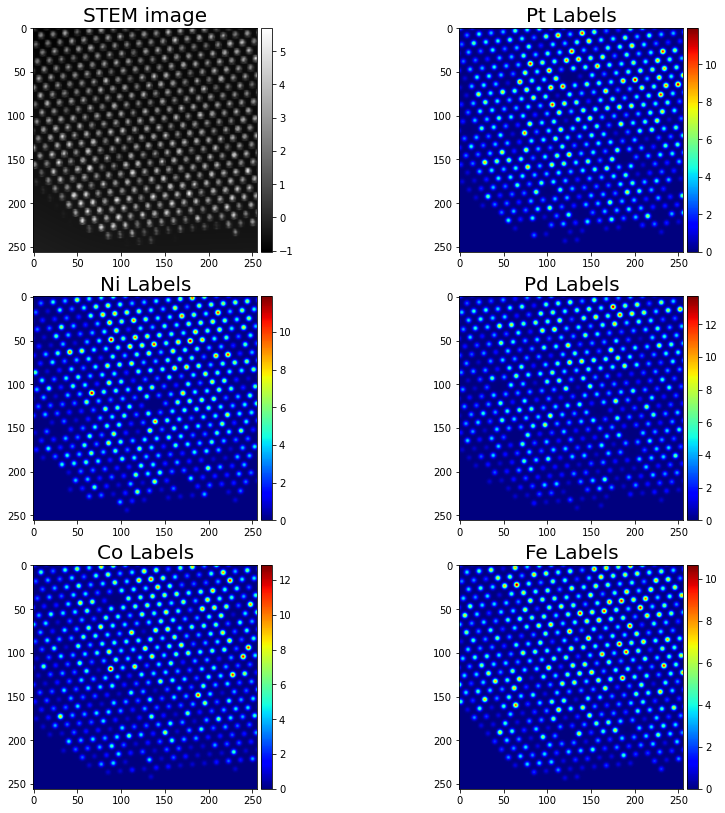

In [17]:
chemical_symbols = ['Pt','Ni','Pd','Co','Fe']

fig = plt.figure(figsize=(14, 14))

ax = fig.add_subplot(3, 2, 1)
im = ax.imshow(img, cmap='gray')
plt.title('STEM image', fontsize=20)
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax1)

for cs in range(1,len(chemical_symbols) + 1):

    ax = fig.add_subplot(3, 2, cs + 1)
    im = ax.imshow(lbl[:, :, cs - 1], cmap='jet')
    plt.title('{} Labels'.format(chemical_symbols[cs - 1]), fontsize=20)
    divider = make_axes_locatable(ax)
    cax1 = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax1)



## 1.5 Saving the data

The class **HEA_Data** is used to save the simulated data (i.e., simulated HAADF STEM image and CHs label maps) into a training/test directory. Since the input image and the label maps have the same size, **they are concatenated into a single variable and saved into a single and multi-channel numpy array (tensor) and labeled with the index 'data_index'** . The input parameters are:


- **random_HEA_model**: HEA atomic model generated with the Random_HEA class.


- **img**: simulated HAADF STEM image.


- **lbl**: CHs label maps.


- **path**: path to the parent directory containing the saved files. The sub-directories will be:

  - **data**: directory containing the tensor data saved in the numpy files (.npy).
  
  - **models**: directory containing the saved atomic models of HEAs (.xyz).
  
  - **plots**: directory containing the plots of the simulated HAADF STEM image and the Pt CHs label map.

In [13]:
# importing the library

from make_HEA_data_utils import HEA_Data

In [14]:
# defining the input parameters.

path = 'training_data/' # training data directory.
#path = 'test_data/' # test data direcotry.


data_index = 1 # here we have only 1 data to save.

# creating the object HEA_data of the class HEA_Data.
HEA_data = HEA_Data(random_HEA_model,
                    img,
                    lbl,
                    path,
                    data_index)

# saving the data using the 'save_HEA' method.
HEA_data.save_HEA()

# 2. CHs statistical analysis

There are three statistical distributions to consider. First, we consider a distribution describing the number of images in the dataset with a certain amount of columns of of a given CH. Then, we calculate the distribution of different CHs in a single image. Finally, the third distributions describe the fractions of each chemical element in atomic columns.The distributios are calculated for each chemical element.


The distributions are calculated using the **CHs_Distribution** class. Input parameters:

- **path**: path to the directory corresponding to the training data


- **n_elements**: number of chemical_elements in the HEAs structures.


- **ch_min,ch_max**: minumum and maximum CHs to consider in the calculation of the distribution. The minimum CH is 1 (i.e., 1 atom) and the maximum is set to 20 (i.e., 20 atoms), but it could be even less (usully the max CH is around 15 atoms for each element). It should be noted that the distribution is calculated for each element separately, so the CH range is related to a single chemical element, and not to the absolut CHs.


The statistical analysis is conducted here on a **small dataset of 350 images in the directory 'training_data_small/'** for demonstration purpose. 

In [15]:
# importing the library 

from make_statistics_HEA_utils import CHs_Distribution

In [16]:
# defining the input parameters

path = 'training_data-try/'

n_elements = 5

ch_min = 1

ch_max = 20

# creating the object CHs_distr of the class CHs_Distribution

CHs_distr = CHs_Distribution(path,n_elements,ch_min,ch_max)

## 2.1 CHs distributions

The first and second CHs distributions are calculated using the **get_CHs_distribution** method. 

In [17]:
# applying the get_CHs_distribution() method

absolute_CHs_distribution, relative_CHs_distribution = CHs_distr.get_CHs_distribution()

ValueError: Cannot load file containing pickled data when allow_pickle=False

### 2.1.1 Distribution of the number of images with a certain amount of columns with a given CH

We are interested in a distribution which shows how many  images have a certain amount of columns with a CH of interest. In the example the CH of interest is 5. The distribution can be given in terms of number of columns, as well as in terms of fraction of columns. In the histogram below, we can see that the majority of the images (~50%) have a number of columns with CH equal to 5 between 50 and 70 (for each element).

In [ ]:
ch = 5

chemical_symbols = ['Pt','Ni','Pd','Co','Fe']

colors = ['gray','green','blue','pink','red']

ce = 1
fig = plt.figure(figsize=(22,22),dpi = 200)

for ce in range(1, n_elements +1):
    ax = fig.add_subplot(3,2,ce)
    ax.hist(absolute_CHs_distribution[ce - 1][ch -1],
                     np.arange(min(absolute_CHs_distribution[ce - 1][ch -1]),
                               max(absolute_CHs_distribution[ce - 1][ch -1] +1)),color = colors[ce - 1])

    plt.xlabel('N. CH = {}'.format(ch),fontsize = 25)
    plt.ylabel('N. images'.format(ch),fontsize = 25)
    plt.title('{}'.format(chemical_symbols[ce - 1]),fontsize = 25)

In the example below, the distribution is given in terms of fraction of columns. That is, the large part of the images (~50%) have a percentage of columns with CH equal to 5 between 15% and 17%.

In [ ]:
ch = 5

chemical_symbols = ['Pt','Ni','Pd','Co','Fe']

colors = ['gray','green','blue','pink','red']

ce = 1
fig = plt.figure(figsize=(22,22),dpi = 200)

for ce in range(1, n_elements +1):
    ax = fig.add_subplot(3,2,ce)
    ax.hist(relative_CHs_distribution[ce - 1][ch -1],
                     np.arange(min(relative_CHs_distribution[ce - 1][ch -1]),
                               max(relative_CHs_distribution[ce - 1][ch -1]), step = 0.001),color = colors[ce - 1])

    plt.xlabel('% CH = {}'.format(ch),fontsize = 25)
    plt.ylabel('N. images'.format(ch),fontsize = 25)
    plt.title('{}'.format(chemical_symbols[ce - 1]),fontsize = 25)

### 2.1.2 Distribution of the amount of columns with different CHs in an image

We are interest in a distribution which shows the amount of columns with different CHs in an image. The distribution can be given in terms of absolute number of columns, as well as a percentage of columns. The scatterplot below shows the number of columns with different CHs for the image with index 3. The plot shows that CHs 4,5 and 6 are the most populated, with a number between 40 and 50 in this image. This is physically reasomable, considering the size of the HEAs and assuming that the elements are equally distributed.

In [ ]:
data_index = 3

fig = plt.figure(figsize=(8,4),dpi = 200)

for ce in range(1, n_elements + 1):
    
    plt.scatter(np.arange(ch_min,ch_max + 1),
                absolute_CHs_distribution[ce - 1][:,data_index],
                color = colors[ce -1])
    
plt.xlabel('CH',fontsize = 25)
plt.ylabel('N. Columns',fontsize = 25)
plt.legend(chemical_symbols)  


The scatterplot below shows the same distribution, but given in terms of percentage of columns. CHs 4,5, and 6 are the most populated, in a percentage between 15% and 20%. 

In [ ]:
data_index = 3

fig = plt.figure(figsize=(8,4),dpi = 200)

for ce in range(1, n_elements + 1):
    
    plt.scatter(np.arange(ch_min,ch_max + 1),
                relative_CHs_distribution[ce - 1][:,data_index],
                color = colors[ce -1])
    
plt.xlabel('CH',fontsize = 25)
plt.ylabel('N. Columns',fontsize = 25)
plt.legend(chemical_symbols)  

### 2.1.3 Box plots

The distributions in **2.1.1** and **2.2.2** can be combined in a box plot distribution. The box plot below shows that CHs 4,5 and 6 are the most populated and that the majority of images (~ 50% inside the box) have a number of columns with these CHs between 50 and 70 approximately for each element.

In [ ]:
box_plot_distr = []

fig = plt.figure(figsize=(25,25),dpi = 200)

for ce in range(1, n_elements + 1):
    
    box_plot_distr.append([])
    

    for ch in range(ch_min, ch_max + 1):
    
        box_plot_distr[ce -1].append(absolute_CHs_distribution[ce - 1][ch -1])
        
    ax = fig.add_subplot(3,2,ce)
    ax.boxplot(box_plot_distr[ce - 1])
    
    plt.xlabel('CH',fontsize = 25, c = colors[ce - 1])
    plt.ylabel('N. Columns',fontsize = 25, c = colors[ce - 1])
    plt.title('{}'.format(chemical_symbols[ce - 1]),fontsize = 25, c = colors[ce - 1])

The box plot below shows that CHs 4,5 and 6 are the most populated and that the majority of images (~ 50% inside the box) have a percentage of columns with these CHs between 15% and 17% approximately for each element.

In [ ]:
box_plot_distr = []

fig = plt.figure(figsize=(25,25),dpi = 200)

for ce in range(1, n_elements + 1):
    
    box_plot_distr.append([])
    

    for ch in range(ch_min, ch_max + 1):
    
        box_plot_distr[ce -1].append(relative_CHs_distribution[ce - 1][ch -1])
        
    ax = fig.add_subplot(3,2,ce)
    ax.boxplot(box_plot_distr[ce - 1])
    
    plt.xlabel('CH',fontsize = 25, c = colors[ce - 1])
    plt.ylabel('N. Columns',fontsize = 25, c = colors[ce - 1])
    plt.title('{}'.format(chemical_symbols[ce - 1]),fontsize = 25, c = colors[ce - 1])

## 2.2 CHs fraction

We are also interested in the fractions of the five element in each column of a given image (third distribution). We calculate this distribution using the **get_CHs_fraction** mmethod. The equiatomic proportion implies that on average the columns contains the 20% of each element, but local fluctuations are taken into account. For example, a column could have up to a 50% of an element, and also down to 5%. These local fluctuation are expected foe HEAs characterized by elements belonging to different rows of the Table of Elements and with different electronegativity.


In [ ]:
# applying the get_CHs_fraction() method

CHs_fraction = CHs_distr.get_CHs_fraction()

The plot below shows the fraction of each element in the atomic columns for the image with index 10

In [ ]:
data_index = 10

fig = plt.figure(figsize=(16,8),dpi = 200)

for ce in range(1, n_elements + 1):
    
    plt.plot(CHs_fraction[data_index][ce -1,:], color = colors[ce -1])
       
plt.xlabel('Column',fontsize = 25)
plt.ylabel('Column %',fontsize = 25)
plt.legend(chemical_symbols)  

# 3. STEM Intensity-CHs correlations

We study the correlations between the pixel intensities in the simulated HAADF STEM images and the CHs for each chemical element. For this task, we use the class **I_CHs_Correlation** and the corresponding **get_I_CHs_correlation()** method.

In [ ]:
# importing the library 

from make_statistics_HEA_utils import I_CHs_Correlation

In [ ]:
# definint the input parameters

path = 'training_data_small/'
n_elements = 5

# definint the object I_CHs_corr of the class I_CHs_Correlation

I_CHs_corr = I_CHs_Correlation(path,n_elements)


# applying the get_I_CHs_correlation() method

I_absolute_CHs_correlation, I_relative_CHs_correlation  = I_CHs_corr.get_I_CHs_correlation()

The scatter-plot below shows that the correlations between the peaks intensities in the STEM image (index 3) and the CHs for each element is highly non-linear, since the data cloud in the scatter-plot are highly dispersed. In STEM images of a single element alloy the relationship is linear, but when multiple elements are combined, the correlations get more complicated. The objective of our Deep Learning model is to capture this non-linear correlation.

In [ ]:
data_index = 3

fig = plt.figure(figsize=(22,22),dpi = 200)

for ce in range(1, n_elements + 1):
    
    ax = fig.add_subplot(3,2,ce)
    ax.scatter(I_absolute_CHs_correlation[data_index][ce - 1][:,0],
               I_absolute_CHs_correlation[data_index][ce - 1][:,1],
               c = colors[ce -1])
    
    plt.xlabel('CHs',fontsize = 25)
    plt.ylabel('I',fontsize = 25)
    plt.title(chemical_symbols[ce - 1], fontsize = 25)
    
    

We perform a linear fit of the I-CHs correlation in order to compare with a typical linear STEM relationship. The R2 of the linear fit indicates how much the correlation deviates from a linear profile, while the slope suggests about the tendency of an increased intensity for higher CHs. The linear fit is performed using the **LinearRegression** class from the **Scikit-Learn** library for Machine Learning algorithms.

In [ ]:
# importing the LinearRegression class from Scikit-Learn

from sklearn.linear_model import LinearRegression

In [ ]:
# fitting the linear regression for each chemical element to calculate R2 and slope of the correlations

for ce in range(1, n_elements + 1):
    
    lr = LinearRegression()

    lr.fit(I_absolute_CHs_correlation[data_index][ce - 1][:,0].reshape(-1,1), 
           I_absolute_CHs_correlation[data_index][ce - 1][:,1].reshape(-1,1))

    R2 = lr.score(I_absolute_CHs_correlation[data_index][ce - 1][:,0].reshape(-1,1), 
                   I_absolute_CHs_correlation[data_index][ce - 1][:,1].reshape(-1,1))
    
    slope = lr.coef_[0][0]
    
    print('{} I-CHs correlation: R2 score = {:.4f}, slope = {:.4f}'.format(chemical_symbols[ce - 1],R2,slope))

The linear fit suggests that for this image, Pt and Pd are the elements with higher R2 and slope, respectively 0.2762 and 0.2599 for Pt, and 0.0563 and 0.1231 for Pd. Ni, Co and Fe have a very low R2 and slope. The analysis is performed for a single image in the dataset (index 3), but we have realized that such trend is repeated in the entire dataset. Thus, Pt has the correlation which is closest to a linear STEM behavior, followed by Pd. Thus, it is expected that the neural network will perform more accurately for these elements since the correlation is "more straightforward" compared to Ni, Co and Fe.


A similar analysis could be done also comparing the intensity I to the fractions of each element in the columns rather then the absolute CHs. The scatter-plots and the linear fit are illustrated below.


In [ ]:
data_index = 3

fig = plt.figure(figsize=(22,22),dpi = 200)

for ce in range(1, n_elements + 1):
    
    ax = fig.add_subplot(3,2,ce)
    ax.scatter(I_relative_CHs_correlation[data_index][ce - 1][:,0],
               I_relative_CHs_correlation[data_index][ce - 1][:,1],
               c = colors[ce -1])
    
    plt.xlabel('CHs',fontsize = 25)
    plt.ylabel('I',fontsize = 25)
    plt.title(chemical_symbols[ce - 1], fontsize = 25)
    

In [ ]:
# fitting the linear regression for each chemical element to calculate R2 and slope of the correlations

for ce in range(1, n_elements + 1):
    
    lr = LinearRegression()

    lr.fit(I_relative_CHs_correlation[data_index][ce - 1][:,0].reshape(-1,1), 
           I_relative_CHs_correlation[data_index][ce - 1][:,1].reshape(-1,1))

    R2 = lr.score(I_relative_CHs_correlation[data_index][ce - 1][:,0].reshape(-1,1), 
                   I_relative_CHs_correlation[data_index][ce - 1][:,1].reshape(-1,1))
    
    slope = lr.coef_[0][0]
    
    print('{} I-CHs correlation: R2 score = {:.4f}, slope = {:.4f}'.format(chemical_symbols[ce - 1],R2,slope))